In [37]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.feature_selection import RFE
import code_demo_lib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload  
reload(code_demo_lib)

<module 'code_demo_lib' from '/home/sean/Dropbox/MyDocuments/Programming/CS156B/CS156B-Covid-Challenge/code_demo_lib.py'>

In [38]:
code_demo_lib.process_jhu()
code_demo_lib.init_county_centers()
code_demo_lib.merge_centers_with_jhu()
code_demo_lib.init_bookings_data()

In [7]:
features = ['State', 'Area_Name','POP_ESTIMATE_2018', 'Area in square miles - Land area', 'Density per square mile of land area - Population', 'Total_Male', 'Total_Female', 'Total_age0to17', 
            'Total_age18to64','Total_age65plus', 'Active Physicians per 100000 Population 2018 (AAMC)', 'Active General Surgeons per 100000 Population 2018 (AAMC)',
           'Non-profit hospital beds per 1000 people (2019)', 'Employed_2018', 'Unemployment_rate_2018'
           , 'Total hospital beds per 1000 people (2019)', 'Total nurse practitioners (2019)',
           'Total Hospitals (2019)','fips','pclon10', 'pclat10']

In [8]:
delta_death_counter = code_demo_lib.DeltaDeathCounter()
delta_case_counter = code_demo_lib.DeltaCaseCounter()
delta_death_ratio_counter = code_demo_lib.RatioCounter(delta_death_counter)
delta_case_ratio_counter = code_demo_lib.RatioCounter(delta_case_counter)
cum_death_counter = code_demo_lib.CumDeathCounter()
cum_case_counter = code_demo_lib.CumCaseCounter()
delta_case_counter = code_demo_lib.DeltaCounter(cum_case_counter)
mobility_counter = code_demo_lib.MobilityCounter()

/home/sean/Dropbox/MyDocuments/Programming/CS156B/CS156B-Covid-Challenge/code_demo_lib.py:291: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  counties['fips'] = counties['fips'].map(lambda f: int(f))


/home/sean/Dropbox/MyDocuments/Programming/CS156B/CS156B-Covid-Challenge/code_demo_lib.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  county_data['date'] = county_data['date'].map(lambda l: (get_date(l) - get_date('2020-01-01')).days)


## Training

In [9]:
large_fips, small_fips = code_demo_lib.split_fips(cum_death_counter,min_thresh=1)

In [10]:
X,y,y_cases = code_demo_lib.get_XY_with_neighs(code_demo_lib.df_jhu_merged, 1, 10, delta_death_counter, 
                         fips_list=large_fips, offset=1, features=features, add_cases=True, 
                                               delta_case_counter=delta_case_counter, mobility_counter=mobility_counter)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

Optimum number of features: 12
Score with 12 features: 0.858517


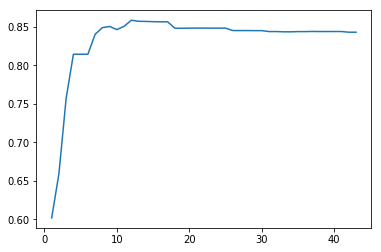

In [11]:
nof_list=np.arange(1,44)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
plt.plot(nof_list, score_list)
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

In [12]:
model = LinearRegression()
rfe = RFE(model,nof)
X_train_rfe = rfe.fit_transform(X_train,y_train)
X_test_rfe = rfe.transform(X_test)
model.fit(X_train_rfe,y_train)
print(model.score(X_test_rfe,y_test))
support = rfe.support_

0.8585174603497957


In [13]:
good_cols = []
for i in range(len(support)):
    if support[i]:
        good_cols.append(X_train.columns[i])
good_cols

['Non-profit hospital beds per 1000 people (2019)',
 'Total hospital beds per 1000 people (2019)',
 'deaths 1 days ago',
 'deaths 3 days ago',
 'deaths 4 days ago',
 'deaths 5 days ago',
 'deaths 6 days ago',
 'deaths 7 days ago',
 'deaths 8 days ago',
 'deaths 9 days ago',
 'neighbor3_deaths',
 'neighbor5_deaths']

In [14]:
X_train_filtered = X_train[good_cols]
X_test_filtered = X_test[good_cols]

In [15]:
normal_model = LinearRegression().fit(X_train_filtered.values, y_train)
print("Ordinary Least Squares")
print("R^2 (in sample): %f" % normal_model.score(X_train_filtered,y_train))
print("R^2 (out sample): %f" % normal_model.score(X_test_filtered,y_test))

Ordinary Least Squares
R^2 (in sample): 0.786734
R^2 (out sample): 0.858517


### Predicting Cases

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cases, test_size=0.4)
X_train_filtered = X_train[good_cols]
X_test_filtered = X_test[good_cols]

Ordinary Least Squares
R^2 (in sample): 0.440664
R^2 (out sample): 0.349239
Ridge Model
R^2 (in sample): 0.440653
R^2 (out sample): 0.348973
Lasso Model
R^2 (in sample): 0.439821
R^2 (out sample): 0.351594


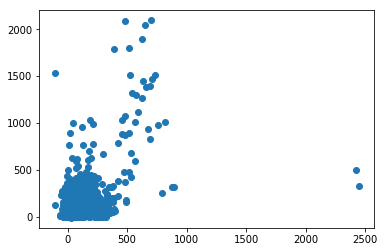

In [17]:
normal_model_cases = LinearRegression().fit(X_train_filtered.values, y_train)
print("Ordinary Least Squares")
print("R^2 (in sample): %f" % normal_model_cases.score(X_train_filtered,y_train))
print("R^2 (out sample): %f" % normal_model_cases.score(X_test_filtered,y_test))
ridge_model_cases = Ridge(alpha=1000)
ridge_model_cases.fit(X_train_filtered.values, y_train)
print("Ridge Model")
print("R^2 (in sample): %f" % ridge_model_cases.score(X_train_filtered,y_train))
print("R^2 (out sample): %f" % ridge_model_cases.score(X_test_filtered,y_test))
lasso_model_cases = Lasso(alpha=1)
lasso_model_cases.fit(X_train_filtered.values, y_train)
print("Lasso Model")
print("R^2 (in sample): %f" % lasso_model_cases.score(X_train_filtered,y_train))
print("R^2 (out sample): %f" % lasso_model_cases.score(X_test_filtered,y_test))

# Generating A Prediction

In [18]:
df_true,_ = code_demo_lib.get_XY_with_neighs(code_demo_lib.df_jhu_merged, 0, 10, delta_death_counter, fips_list=large_fips, 
                                             moving_window=False, offset=0, features=features,delta_case_counter=delta_case_counter, mobility_counter=mobility_counter)
percentile_to_zscore = {10:-1.282, 20:-0.842,30:-0.524,40:-0.253,50:0,60:0.253,70:0.524,80:0.842,90:1.282}
df_true = df_true.set_index('fips')

In [19]:
output = code_demo_lib.get_percentile_obj(normal_model, df_true,good_cols, max_look_ahead=14,cases_predictor=normal_model_cases)
output_rand = code_demo_lib.get_percentile_obj_rand(normal_model, df_true, good_cols, max_look_ahead=14)

## Sample Prediction

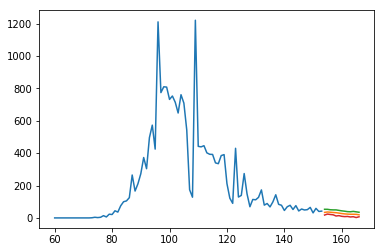

In [20]:
fips = 36061
y_50 = []
y_10 = []
y_90 = []
for i in range(1,14):
    y_50.append(output_rand[i][fips][50])
    y_10.append(output_rand[i][fips][10])
    y_90.append(output_rand[i][fips][90])

t, ys = delta_death_counter.getY(fips)
plt.plot(t,ys)
plt.plot(t[-1] +  range(1,14),y_50)
plt.plot(t[-1] +  range(1,14),y_90)
plt.plot(t[-1] +  range(1,14),y_10)

Blue line is actual historical data. Orange stands for 50 percentile prediction, red for 10 percentile, green for 90 percentile

In [39]:
code_demo_lib.write_percentiles(output_rand, 'submission_test.csv', 14, offset=0, delta_death_counter=delta_death_counter)
your_submission = pd.read_csv('submission_test.csv').set_index('id').sort_index()
sample_submission = pd.read_csv("sample_submission.csv").set_index('id').sort_index()
assert(your_submission.index.equals(sample_submission.index))